In [99]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [100]:
f = fits.open(r"C:\code\astrocam\images\Image00016_4.0sec_120gain_31.1C.fit")
#f = fits.open('output.fits')

In [101]:
ph = f[0]


In [102]:
for k,v in ph.header.items():
  print(k,v)

SIMPLE True
BITPIX 16
NAXIS 2
NAXIS1 4144
NAXIS2 2822
COMMENT Anand Dinakar
OBJECT M31
INSTRUME ZWO ASI294MC Pro
DATE-OBS 2022-08-15T16:26:33
EXPTIME 4.0
CCD-TEMP 31.1
XPIXSZ 4.63
YPIXSZ 4.63
XBINNING 1
YBINNING 1
XORGSUBF 0
YORGSUBF 0
EGAIN 1.002242684364319
FOCALLEN 1764
SWCREATE AstroCAM
SBSTDVER SBFITSEXT Version 1.0
SNAPSHOT 1
SET-TEMP 0.0
IMAGETYP Light Frame
SITELAT +40 51 55.000
SITELONG -74 20 42.000
GAIN 120
OFFSET 0
BAYERPAT RGGB
BSCALE 1
BZERO 32768


In [103]:
img = ph.data

In [104]:
img.dtype, img.shape

(dtype('uint16'), (2822, 4144))

In [105]:
np.iinfo(img.dtype).max


65535

In [106]:
assert(img.shape[0]==ph.header['NAXIS2'])
assert(img.shape[1]==ph.header['NAXIS1'])

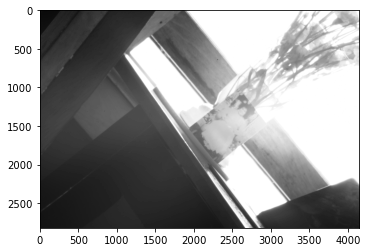

In [107]:
plt.imshow(ph.data, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2822, 4144, 3)


True

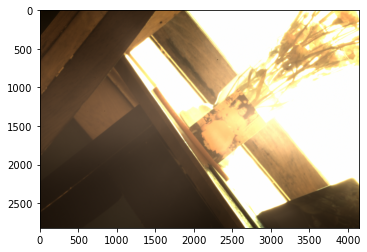

In [108]:
import torch
import importlib
from pathlib import Path

run_path = Path("../mlruns/0/cba518c62db649dfb2c4bd41ce4573ff/artifacts")
from debayer_model import DebayerModel
dm = DebayerModel('cpu', ph.data.shape)
dm.load_state_dict(torch.load(run_path / "weights_00019.pth", map_location=torch.device('cpu')))

bayered = ph.data.astype(np.float32)
bayered = np.expand_dims(np.expand_dims(bayered, axis=0), axis=0)
bayered = bayered - bayered.min()
bayered = bayered / bayered.max()
rgb_f = dm(torch.tensor(bayered))
rgb_i = (rgb_f).detach().numpy().astype(np.float32)
rgb_img = np.transpose(rgb_i[0], axes=(1, 2, 0))
print(rgb_img.shape)
plt.imshow(rgb_img)

import cv2
cv2.imwrite("output.tif", cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR))

In [109]:
np.min(img), np.max(img), np.std(img), np.mean(img), np.median(img)

(8016, 65532, 20824.196489898168, 38498.432950630595, 30732.0)

In [110]:
def norm(img):
  img = img - np.min(img)
  img = img / np.max(img)
  return img
def debayer(img, method=cv2.COLOR_BAYER_BG2RGB):
  deb = cv2.cvtColor(img, method)
  norm_deb = np.stack([norm(deb[:,:,0]), norm(deb[:,:,1]), norm(deb[:,:,2])], axis=2)
  return norm_deb.astype(np.float32)

cv2.imwrite(r"C:\Users\anand\Desktop\output-default.tif", debayer(img, cv2.COLOR_BAYER_BG2RGB))
cv2.imwrite(r"C:\Users\anand\Desktop\output-ea.tif", debayer(img, cv2.COLOR_BAYER_BG2RGB_EA)) ## Edge aware
#cv2.imwrite(r"C:\Users\anand\Desktop\output-vng.tif", debayer(img, cv2.COLOR_BAYER_BG2RGB_VNG))

True

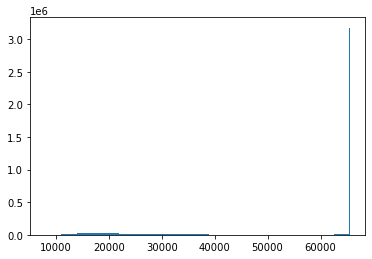

In [111]:
a,b,c = plt.hist(img.ravel(), bins=1000)

In [112]:
h = img.shape[0]
w = img.shape[1]

In [113]:
r = img[0:h:2, 0:w:2]
b = img[1:h:2, 1:w:2]
g1 = img[0:h:2, 1:w:2]
g2 = img[1:h:2, 0:w:2]
g = (g1+g2)/2

In [114]:
assert(r.shape==b.shape)
assert(r.shape==g.shape)

'min:0.0, max:1.0, mean:0.5802865187828374'

'min:0.0, max:1.0, mean:0.5227407672017376'

'min:0.0, max:1.0, mean:0.5204322431975483'

'min:0.0, max:1.0, mean:0.43795584935909904'

'min:0.0, max:1.0, mean:0.7011545321828526'

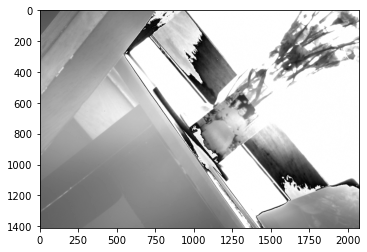

In [115]:
def info(img):
  plt.imshow(img, cmap='gray')
  display(f"min:{np.min(img)}, max:{np.max(img)}, mean:{np.mean(img)}")

info(norm(r))
info(norm(g1))
info(norm(g2))
info(norm(b))
info(norm(g))

In [116]:
cimg = np.stack([norm(r), norm(g), norm(b)], axis=2)

In [117]:
cimg.shape

(1411, 2072, 3)

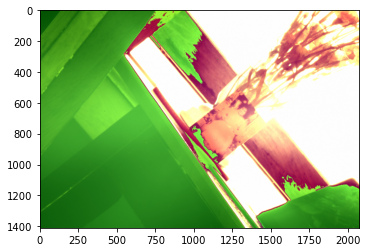

In [118]:
plt.imshow(cimg)
plt.imsave(r"C:\Users\anand\Desktop\output.png", cimg, dpi=300)

In [119]:
cv2.imwrite(r"C:\Users\anand\Desktop\output.tif", cimg.astype(np.float32))

True